## Import Thư viện

In [1]:
# tiền xử lý
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats

# mô hình phân loại
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# đánh giá mô hình
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

# trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện khác
import os
import joblib
from sklearn.model_selection import GridSearchCV
import json

## Kiểm tra dữ liệu ban đầu

Load data

In [2]:
df = pd.read_csv("../DATASET/weather_classification_data.csv")
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


Xem cấu trúc dữ liệu

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [4]:
print("This data has {} rows and {} columns".format(df.shape[0], df.shape[1]))

This data has 13200 rows and 11 columns


Thống kê giá trị bị khuyết

In [5]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

Thống kê mô tả dữ liệu

In [6]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


In [7]:
# Thống kê tần suất các giá trị ở mỗi biến phân loại
for column in df.select_dtypes(include=['object', 'category']).columns:
    print(df[column].value_counts())


Cloud Cover
overcast         6090
partly cloudy    4560
clear            2139
cloudy            411
Name: count, dtype: int64
Season
Winter    5610
Spring    2598
Autumn    2500
Summer    2492
Name: count, dtype: int64
Location
inland      4816
mountain    4813
coastal     3571
Name: count, dtype: int64
Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64


In [8]:
# Kiểm tra giá trị trùng lặp
df.duplicated().sum()

0

## Phân tích biến và trực quan hóa

### Phân tích đơn biến

Biểu đồ thể hiện tần suất của các biến phân loại

In [9]:
# tạo danh sách các biến phân loại
categorical_cols = df. select_dtypes(exclude='number').columns
print(f'Categorical columns: {categorical_cols}')

Categorical columns: Index(['Cloud Cover', 'Season', 'Location', 'Weather Type'], dtype='object')


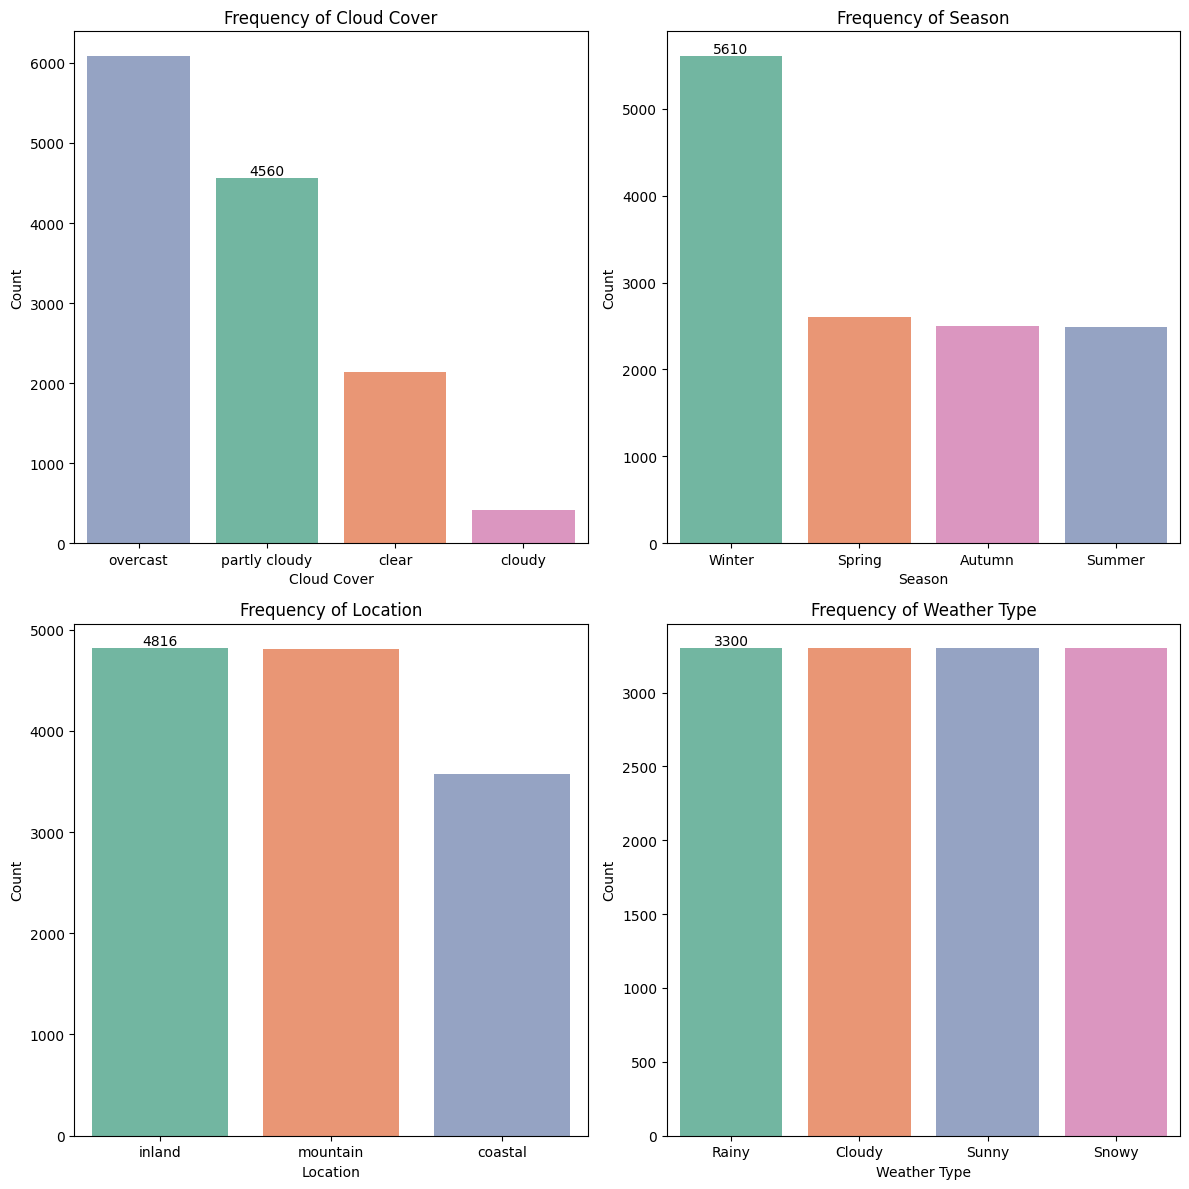

In [10]:
plt.figure(figsize=(12, 12))

# Vẽ các biểu đồ
for i, column in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)  # Vị trí của subplot
    ax = sns.countplot(
        data=df, 
        x=column, 
        hue=column,  # Gán `x` vào `hue` để tránh cảnh báo
        order=df[column].value_counts().index, 
        palette="Set2", 
        legend=False  # Tắt chú thích
    )
    
    # Lấy số liệu của các biến
    abs_values = df[column].value_counts(ascending=False).values
    
    # Thêm số liệu trên các thanh
    if ax.containers and len(ax.containers[0]) > 0:  # Kiểm tra container không rỗng
        ax.bar_label(ax.containers[0])
    
    plt.title(f"Frequency of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks()  

# Căn chỉnh layout
plt.tight_layout()
plt.show()


Biểu đồ thể hiện phân phối của các biến số

In [11]:
numerical_cols=df.select_dtypes(include='number').columns
print(f"Numerical Columns: {numerical_cols}")

Numerical Columns: Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')


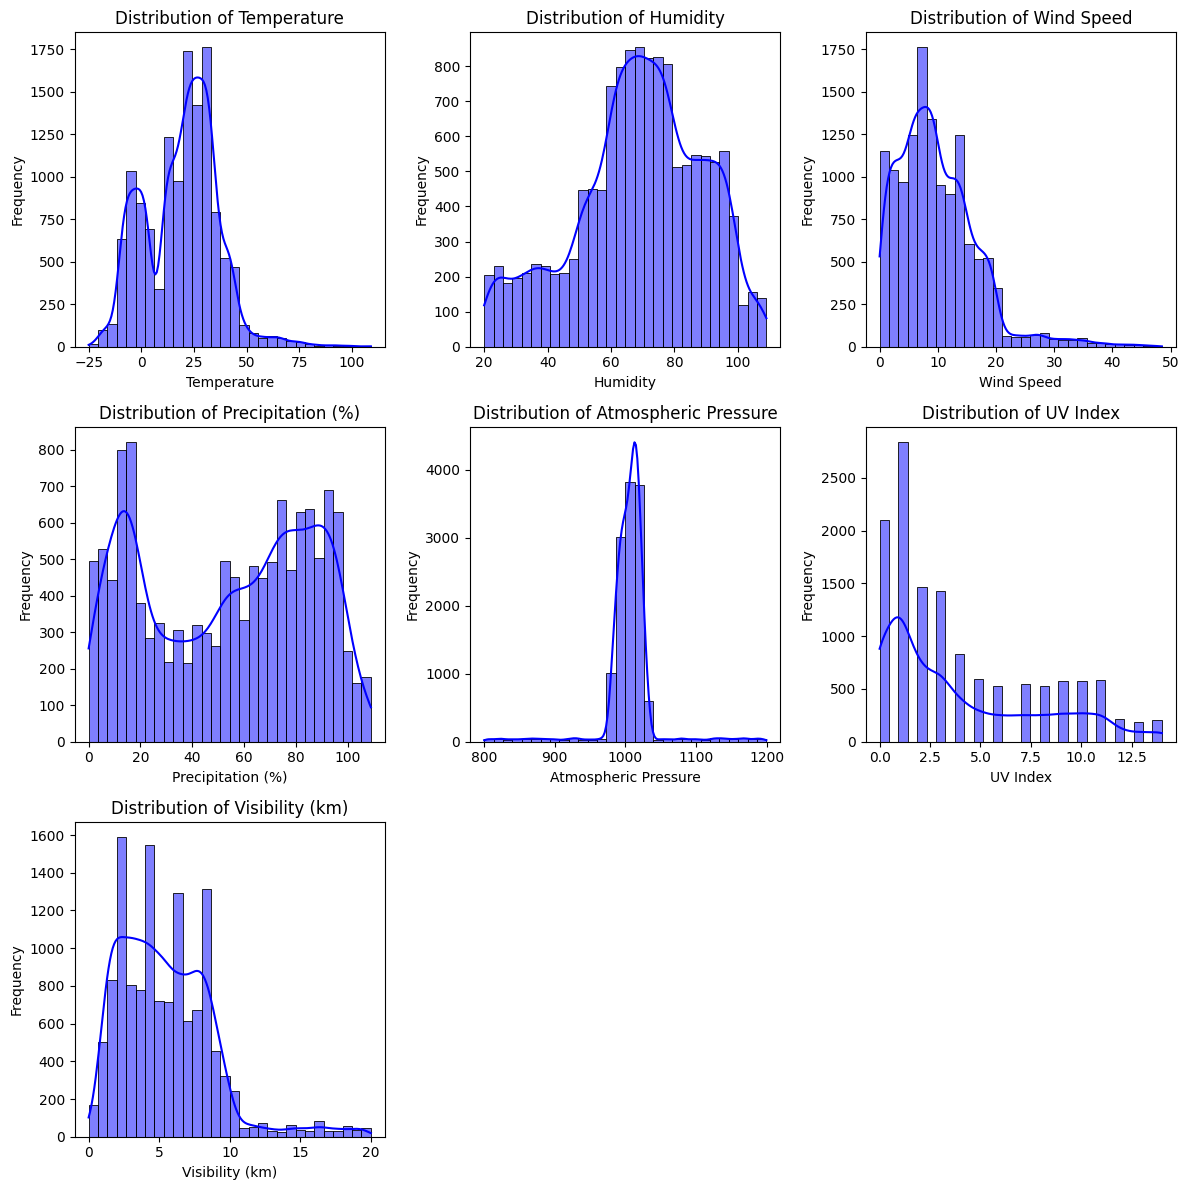

In [12]:
# Xác định số lượng hàng và cột cho lưới
n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(12, n_rows * 4))

# Vẽ biểu đồ phân phối cho từng biến số
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)  # Vị trí của subplot
    sns.histplot(df[column], kde=True, bins=30, color="blue")  # Vẽ histogram với KDE (Kernel Density Estimate)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

# Căn chỉnh layout
plt.tight_layout()
plt.show()


Một cách nhìn khác của phân phối để xác định có giá trị ngoại lai hay không

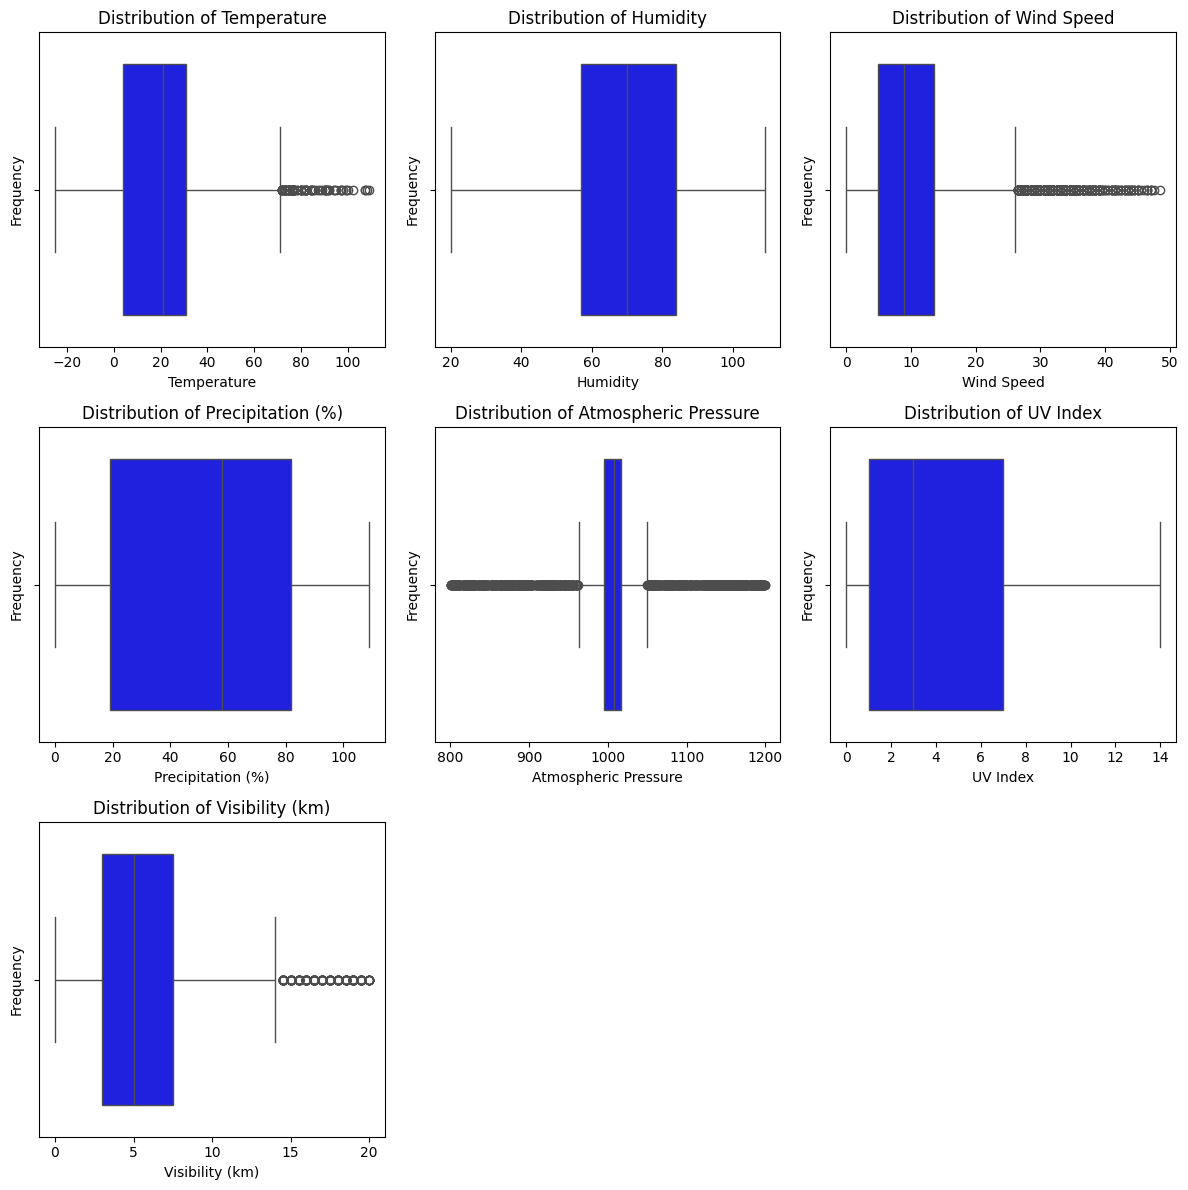

In [13]:
# Xác định số lượng hàng và cột cho lưới
n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(12, n_rows * 4))

# Vẽ biểu đồ phân phối cho từng biến số
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)  # Vị trí của subplot
    sns.boxplot(data=df, x=column, color="blue")  # Vẽ boxplot
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

# Căn chỉnh layout
plt.tight_layout()
plt.show()


Từ các biểu đồ trên có thể nhận thấy các biến như Tempurature, Wind Speed, Visibility, Atmospheric Pressure có thể chứa các giá trị ngoại lai.

### Phân tích 2 biến (Mối quan hệ giữa biến mục tiêu Weather Type và các biến khác)

Thống kê giá trị trung bình của từng biến số theo các nhóm giá trị trong Weather Type

In [14]:
def target_summary_with_numeric(df: pd.DataFrame, target: str, numerical_cols):
    # Tạo dictionary để lưu trữ kết quả cho từng cột
    result_dict = {}
    
    for col in numerical_cols:
        # Tính toán trung bình theo target cho mỗi cột
        result_dict[col] = df.groupby(target).agg({col: "mean"})
    
    # Kết hợp các kết quả thành một DataFrame duy nhất
    result_df = pd.concat(result_dict, axis=1)
    
    # Đổi tên cột để dễ hiểu hơn (nếu cần)
    result_df.columns = [f"Mean of {col}" for col in numerical_cols]
    
    return result_df

result_df = target_summary_with_numeric(df, "Weather Type", numerical_cols)

# Hiển thị kết quả
result_df

,Mean of Temperature,Mean of Humidity,Mean of Wind Speed,Mean of Precipitation (%),Mean of Atmospheric Pressure,Mean of UV Index,Mean of Visibility (km)
Weather Type,,,,,,,
Cloudy,22.823636,66.528788,8.601818,40.286364,1010.170724,3.583939,7.071212
Rainy,22.788182,78.397879,13.677576,74.752424,1004.149848,2.684242,3.628485
Snowy,-1.530606,78.510303,10.976212,74.586061,991.051842,1.950303,3.591515
Sunny,32.429091,51.406364,6.073182,24.952727,1017.939170,7.804545,7.560455


Biểu đồ thể hiện ảnh hưởng của các biến như Tempurature, Humidity và Precipitation theo Cloud Cover

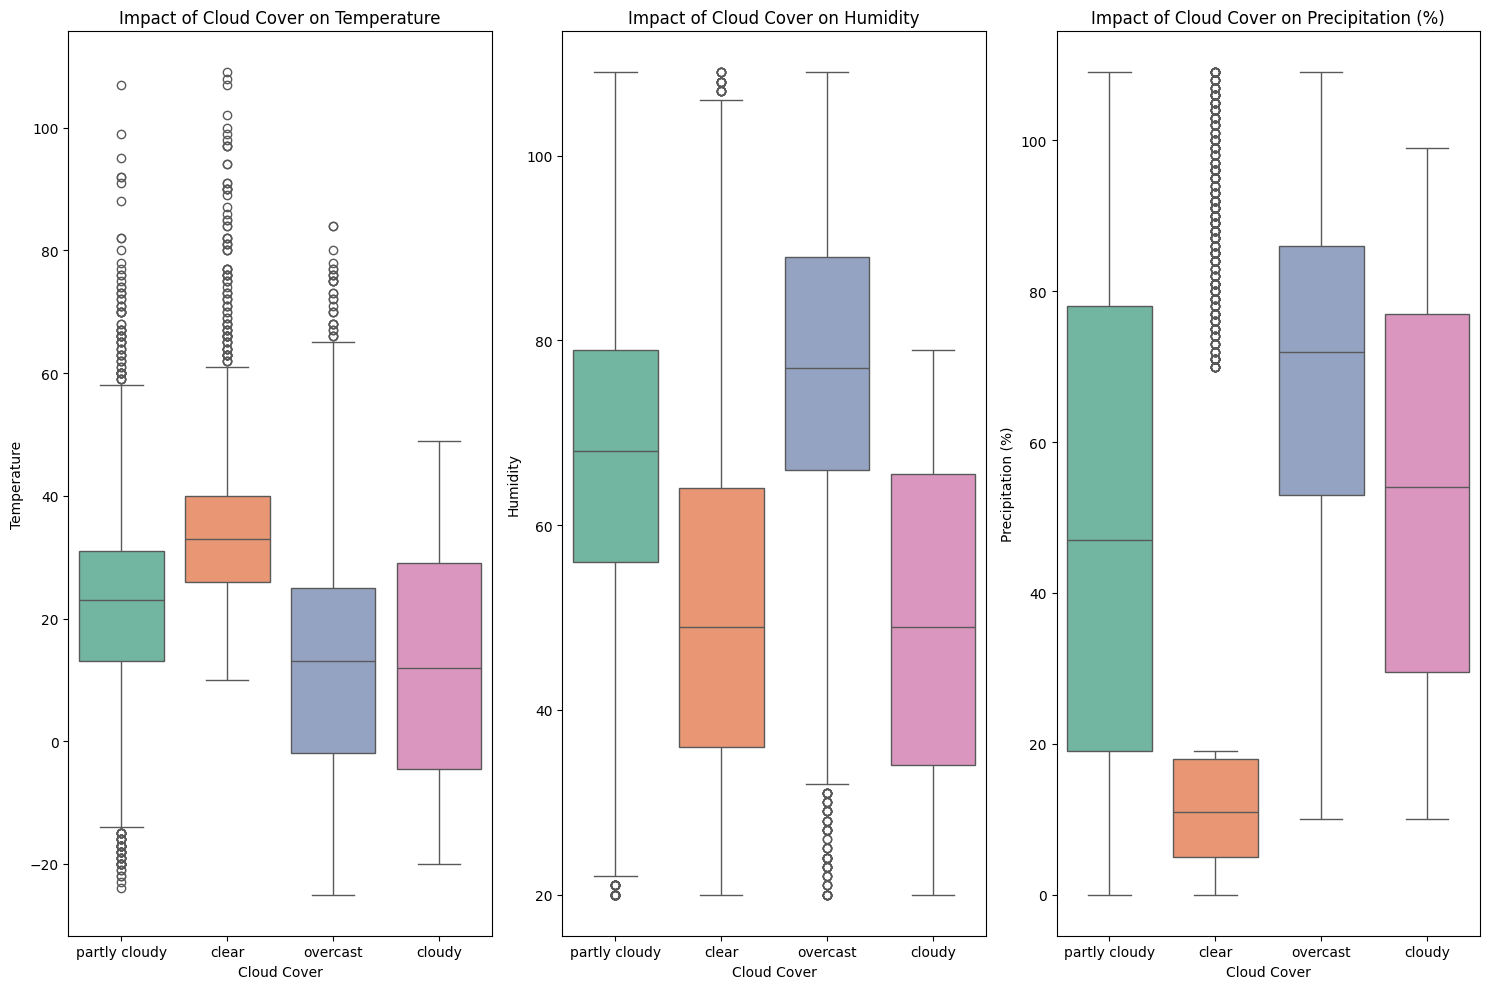

In [15]:
# Xác định các biến cần vẽ biểu đồ
variables = ['Temperature', 'Humidity', 'Precipitation (%)']

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(15, 10))

# Vẽ biểu đồ cho từng biến
for i, variable in enumerate(variables, 1):
    plt.subplot(1, 3, i)  # Vị trí của subplot (1 hàng, 3 cột)
    sns.boxplot(x='Cloud Cover', hue='Cloud Cover', y=variable, data=df, palette="Set2", legend=False)
    plt.title(f'Impact of Cloud Cover on {variable}')
    plt.xlabel('Cloud Cover')
    plt.ylabel(variable)

# Căn chỉnh layout để tránh chồng lấn
plt.tight_layout()
plt.show()


Biểu đồ thể hiện sự tương quan giữa các yếu tố khí tượng

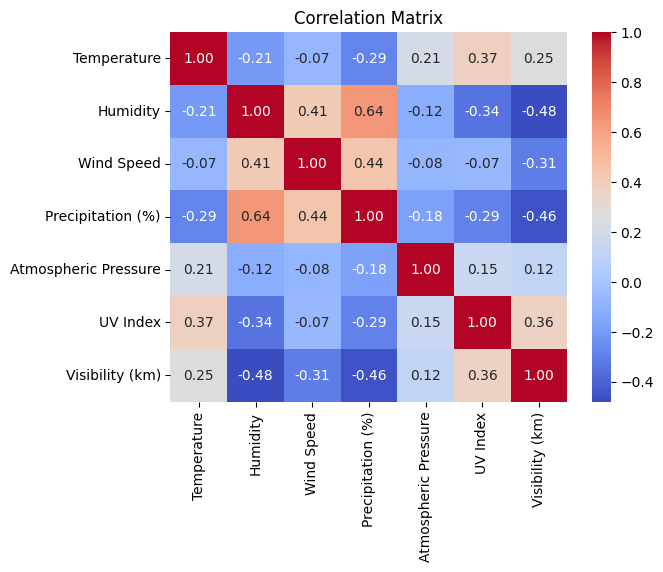

In [16]:
corr =  df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

Kiểm tra sự ảnh hưởng của các biến số tới biến mục tiêu bằng kiểm định ANOVA

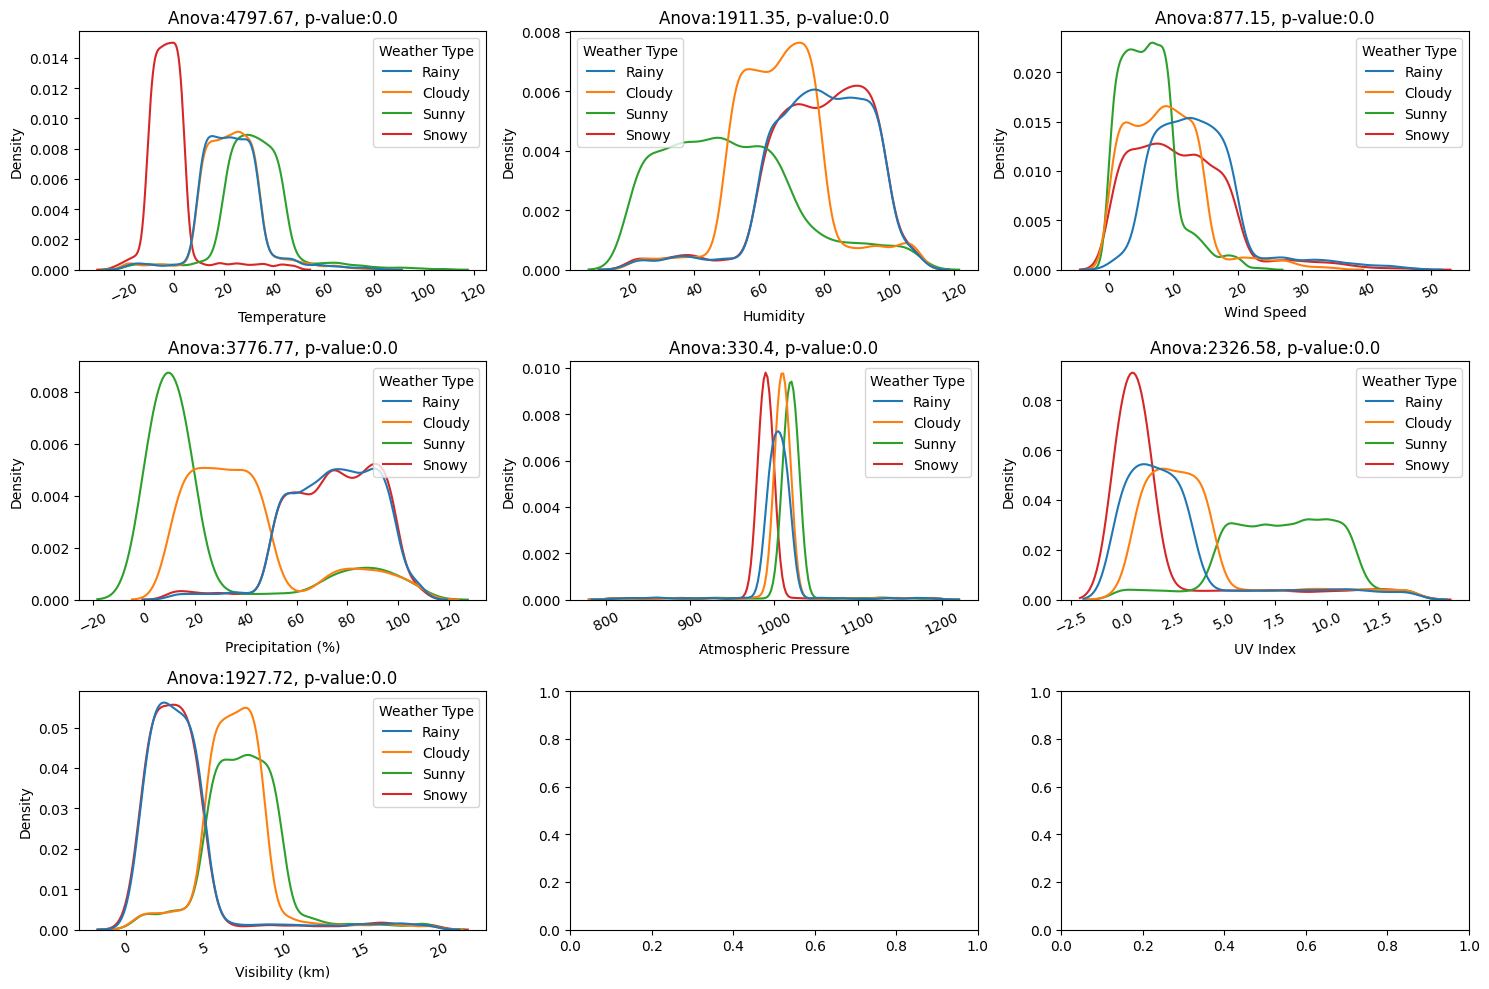

In [17]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(15,10))
ax = ax.flatten()
i=0
num_selected=[]
for col in numerical_cols:
    k=dict(list(df.groupby("Weather Type")[col]))
    f,p=stats.f_oneway(*k.values())
    text_str=f"Anova:{round(f,2)}, p-value:{round(p,2)}"

    if p<0.05 and col not in num_selected:
            num_selected.append(col)
        
    sns.kdeplot(data=df,x=col,hue="Weather Type",ax=ax[i])
    ax[i].set_title(text_str)
    ax[i].tick_params(axis='x', rotation=25)
    i+=1
        
plt.tight_layout()
plt.show()

Kết quả kiểm định cho thấy rằng, tất cả các biến đều có ảnh hưởng nhất định tới biến mục tiêu.

## Xử lý tiền huấn luyện

Như các phân tích trước đó, một số biến số như Tempurature, Precitipation... có xuất hiện các giá trị ngoại lai. Nhóm sẽ tiến hành loại bỏ chúng trong phần này.

Xác định giá trị ngoại lai cho từng cột

In [18]:
def detect_outliers(df: pd.DataFrame):
    outliers = {}
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # lưu lại các hàng chứa outliers
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# xuất ra outliers cho mỗi cột 
outliers = detect_outliers(df)
for col, value in outliers.items():
    print(f"Outliers in {col}:")
    print(value, sep="\n")

Outliers in Temperature:
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
210           78.0        81         8.0               78.0       overcast   
228           73.0        82        47.0              107.0       overcast   
535           80.0        76         3.0               93.0          clear   
709           74.0       101        18.0               76.0  partly cloudy   
730           76.0        91        13.5               82.0  partly cloudy   
...            ...       ...         ...                ...            ...   
12752         90.0        83        15.0               98.0          clear   
12814         72.0        88        12.0               83.0          clear   
12878         95.0        96         1.0               84.0  partly cloudy   
13065         97.0        95         7.5               79.0          clear   
13108         81.0        81        10.5               96.0          clear   

       Atmospheric Pressure  UV Index 

Trực quan hóa các giá trị ngoại lai

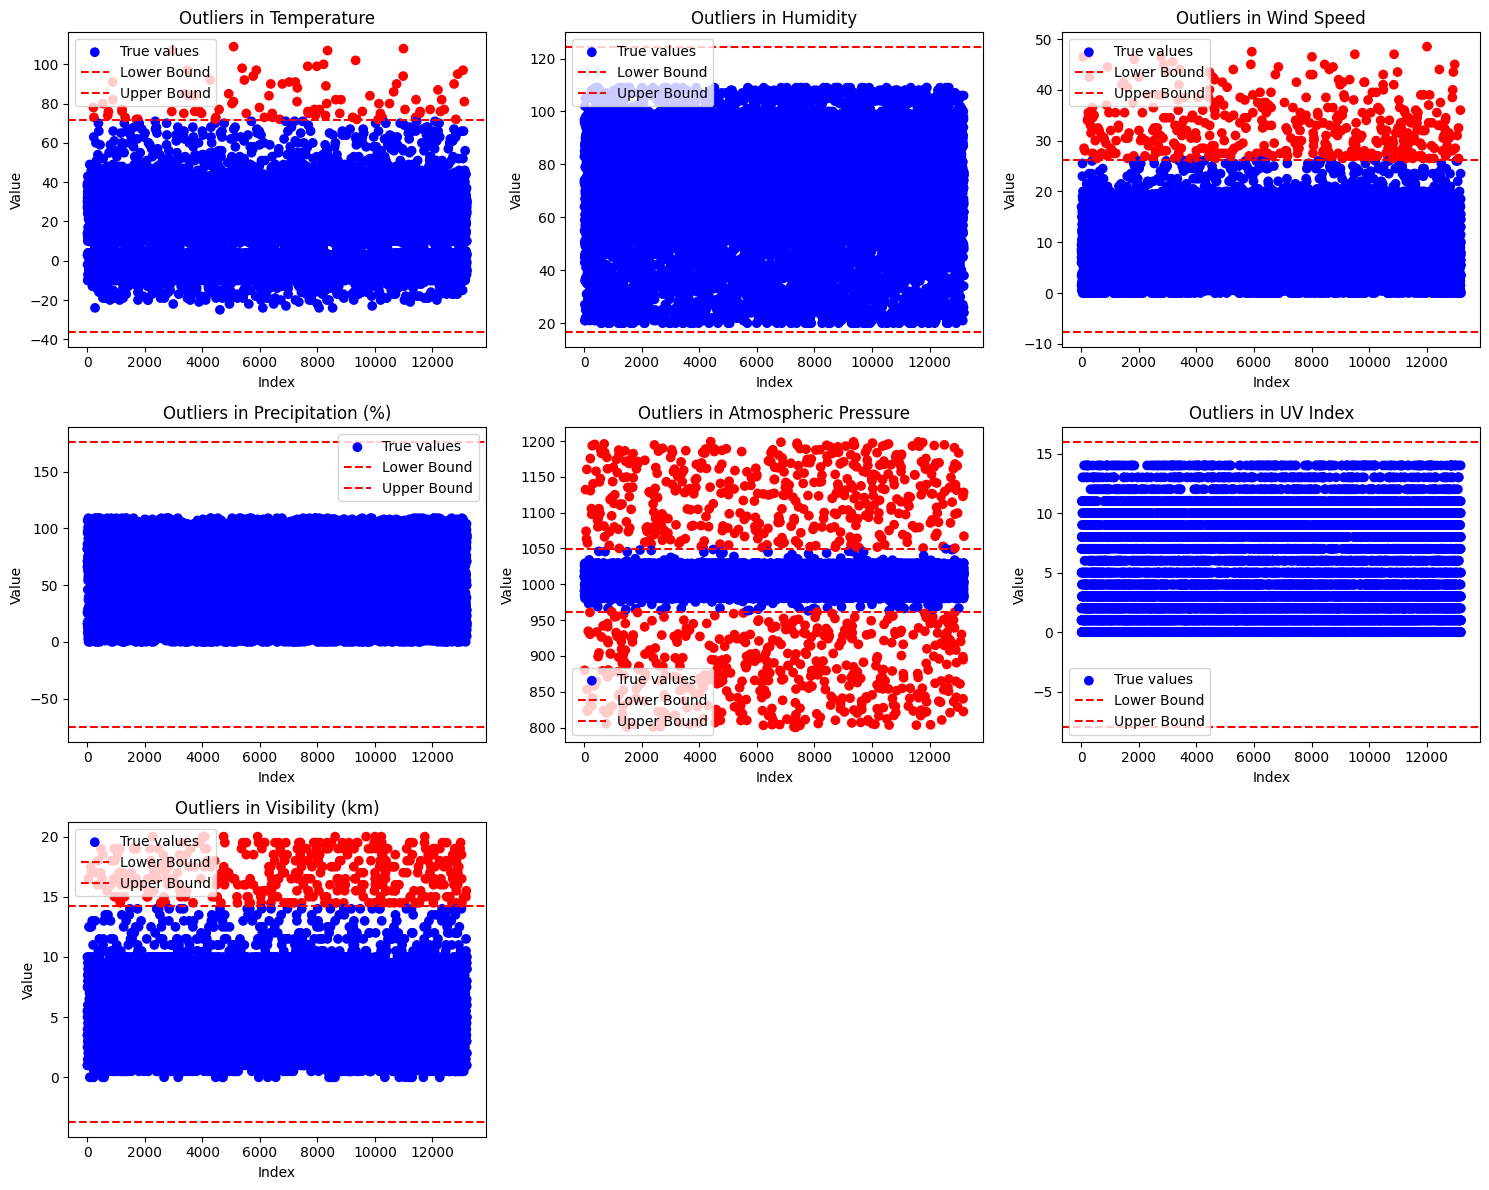

In [19]:
def plot_outliers(df: pd.DataFrame):
    num_cols = len(df.select_dtypes(include='number').columns)
    num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Hiển thị tối đa 3 cột trên mỗi hàng
    plt.figure(figsize=(15, num_rows * 4))

    for i, col in enumerate(df.select_dtypes(include='number').columns, 1):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Xác định outliers
        is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)

        # Chuyển is_outlier sang danh sách để tránh lỗi
        colors = ['red' if outlier else 'blue' for outlier in is_outlier.tolist()]

        # Vẽ Scatter Plot
        plt.subplot(num_rows, 3, i)
        plt.scatter(df.index, df[col], c=colors, label='True values', marker='o')
        plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
        plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
        plt.title(f'Outliers in {col}')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ
plot_outliers(df)


Loại bỏ các outliers

In [20]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    clean_df = df.copy()  # Tạo một bản sao để tránh sửa đổi trực tiếp
    for col in clean_df.select_dtypes(include='number').columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Giữ lại các hàng nằm trong khoảng hợp lệ
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
    
    return clean_df

cleaned_df = remove_outliers(df)
cleaned_df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13194,29.0,62,13.0,17.0,overcast,1002.81,2,Spring,5.0,coastal,Cloudy
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [21]:
print(f"Số dòng trước khi lọc: {len(df)}")
print(f"Số dòng sau khi lọc: {len(cleaned_df)}")

Số dòng trước khi lọc: 13200
Số dòng sau khi lọc: 11586


In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11586 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           11586 non-null  float64
 1   Humidity              11586 non-null  int64  
 2   Wind Speed            11586 non-null  float64
 3   Precipitation (%)     11586 non-null  float64
 4   Cloud Cover           11586 non-null  object 
 5   Atmospheric Pressure  11586 non-null  float64
 6   UV Index              11586 non-null  int64  
 7   Season                11586 non-null  object 
 8   Visibility (km)       11586 non-null  float64
 9   Location              11586 non-null  object 
 10  Weather Type          11586 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


Chia dữ liệu

In [23]:
# Tạo biến mục tiêu
target = "Weather Type"

# Tách X và Y
Y = cleaned_df[target]
X = cleaned_df.drop(columns=[target])

print(X.head())
print(Y.head())

   Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0        73         9.5               82.0  partly cloudy   
1         39.0        96         8.5               71.0  partly cloudy   
2         30.0        64         7.0               16.0          clear   
3         38.0        83         1.5               82.0          clear   
4         27.0        74        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  
0               1010.82         2  Winter              3.5    inland  
1               1011.43         7  Spring             10.0    inland  
2               1018.72         5  Spring              5.5  mountain  
3               1026.25         7  Spring              1.0   coastal  
4                990.67         1  Winter              2.5  mountain  
0     Rainy
1    Cloudy
2     Sunny
3     Sunny
4     Rainy
Name: Weather Type, dtype: object


In [24]:
# Chia dữ liệu thành tập train và test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [25]:
X_train

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
2272,27.0,71,17.5,90.0,overcast,995.10,2,Winter,2.5,mountain
5051,25.0,33,1.5,19.0,clear,1015.54,5,Winter,9.0,inland
8378,25.0,48,6.5,15.0,clear,1012.31,6,Winter,10.0,inland
10616,26.0,82,14.5,96.0,overcast,999.91,8,Winter,0.5,inland
11368,11.0,74,18.0,94.0,overcast,1001.37,1,Winter,4.5,inland
...,...,...,...,...,...,...,...,...,...,...
12852,32.0,90,19.0,55.0,overcast,1007.95,0,Summer,1.5,mountain
5843,38.0,63,3.0,8.0,clear,1011.41,5,Spring,5.5,mountain
6071,14.0,70,14.0,29.0,partly cloudy,1007.08,2,Spring,8.5,coastal
975,26.0,61,13.5,73.0,partly cloudy,995.23,2,Autumn,2.0,inland


In [26]:
X_test

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
5671,33.0,73,19.5,93.0,clear,1027.82,2,Winter,6.5,inland
11120,12.0,97,7.0,79.0,overcast,1013.70,1,Summer,2.0,inland
1445,-10.0,85,19.0,71.0,overcast,989.02,0,Winter,2.5,mountain
4531,24.0,39,2.0,10.0,clear,1013.21,10,Spring,8.5,coastal
7374,45.0,102,9.0,86.0,partly cloudy,1011.50,7,Spring,8.5,mountain
...,...,...,...,...,...,...,...,...,...,...
889,16.0,67,9.0,16.0,overcast,1007.01,1,Winter,7.5,mountain
5491,25.0,107,9.5,92.0,overcast,1008.47,11,Summer,4.5,mountain
3808,35.0,24,2.5,4.0,clear,1013.27,8,Winter,6.5,inland
9441,26.0,77,2.5,37.0,partly cloudy,1012.44,2,Summer,8.0,inland


In [27]:
Y_train

2272      Rainy
5051      Sunny
8378      Sunny
10616     Rainy
11368     Rainy
          ...  
12852     Rainy
5843      Sunny
6071     Cloudy
975       Rainy
8231     Cloudy
Name: Weather Type, Length: 9268, dtype: object

In [28]:
Y_test

5671      Sunny
11120     Rainy
1445      Snowy
4531      Sunny
7374      Sunny
          ...  
889      Cloudy
5491      Rainy
3808      Sunny
9441     Cloudy
10636     Snowy
Name: Weather Type, Length: 2318, dtype: object

Mã hóa biến mục tiêu bằng Label Encoder

In [29]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

In [30]:
Y_train

array([1, 3, 3, ..., 0, 1, 0])

In [31]:
Y_test

array([3, 1, 2, ..., 3, 0, 2])

In [32]:
# Kiểm tra ánh xạ giữa giá trị gốc và giá trị mã hóa
print("Giá trị gốc và giá trị mã hóa:")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {i}")

Giá trị gốc và giá trị mã hóa:
Cloudy -> 0
Rainy -> 1
Snowy -> 2
Sunny -> 3


Chuẩn hóa các biến số bằng phân phối chuẩn, sử dụng StandardScaler

In [88]:
ss = StandardScaler()
X_train[numerical_cols] = ss.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = ss.transform(X_test[numerical_cols])

In [89]:
X_train

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
2272,0.509338,0.080583,1.484607,1.190999,overcast,-0.860554,-0.439771,Winter,-1.002087,mountain
5051,0.383253,-1.872224,-1.362496,-1.030227,clear,0.717369,0.418653,Winter,1.497146,inland
8378,0.383253,-1.101379,-0.472776,-1.155366,clear,0.468020,0.704794,Winter,1.881643,inland
10616,0.446295,0.645869,0.950775,1.378708,overcast,-0.489232,1.277077,Winter,-1.771081,inland
11368,-0.499339,0.234752,1.573579,1.316138,overcast,-0.376524,-0.725912,Winter,-0.233092,inland
...,...,...,...,...,...,...,...,...,...,...
12852,0.824549,1.056987,1.751523,0.096028,overcast,0.131438,-1.012054,Summer,-1.386584,mountain
5843,1.202803,-0.330534,-1.095580,-1.374360,clear,0.398542,0.418653,Spring,0.151405,mountain
6071,-0.310212,0.029194,0.861803,-0.717378,partly cloudy,0.064276,-0.439771,Spring,1.304897,coastal
975,0.446295,-0.433313,0.772831,0.659156,partly cloudy,-0.850518,-0.439771,Autumn,-1.194335,inland


In [90]:
X_test

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
5671,0.887591,0.183363,1.840495,1.284853,clear,1.665358,-0.439771,Winter,0.535902,inland
11120,-0.436296,1.416714,-0.383804,0.846865,overcast,0.575325,-0.725912,Summer,-1.194335,inland
1445,-1.823226,0.800038,1.751523,0.596586,overcast,-1.329916,-1.012054,Winter,-1.002087,mountain
4531,0.320211,-1.563886,-1.273524,-1.311790,clear,0.537498,1.849360,Spring,1.304897,coastal
7374,1.644099,1.673663,-0.027917,1.065859,partly cloudy,0.405490,0.990936,Spring,1.304897,mountain
...,...,...,...,...,...,...,...,...,...,...
889,-0.184127,-0.124975,-0.027917,-1.124081,overcast,0.058872,-0.725912,Winter,0.920400,mountain
5491,0.383253,1.930611,0.061055,1.253568,overcast,0.171581,2.135501,Summer,-0.233092,mountain
3808,1.013676,-2.334731,-1.184552,-1.499499,clear,0.542130,1.277077,Winter,0.535902,inland
9441,0.446295,0.388921,-1.184552,-0.467099,partly cloudy,0.478056,-0.439771,Summer,1.112648,inland


Mã hóa các biến phân loại bằng One Hot Encoder

In [91]:
categorical_cols

Index(['Cloud Cover', 'Season', 'Location', 'Weather Type'], dtype='object')

In [92]:
# # Xác định các cột phân loại
# categorical_cols = [col for col in X_train.columns if col not in numerical_cols]



# Tạo bộ mã hóa với ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first', sparse_output=False), categorical_cols[:3])
    ],
    remainder='passthrough'  # Giữ nguyên các cột số
)

# Áp dụng mã hóa trên tập X_train và X_test
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

# Nếu muốn chuyển kết quả về DataFrame
import pandas as pd
X_train_encoded = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test, columns=ct.get_feature_names_out())


In [93]:
# chuyển sang numpy array để đưa vào huấn luyện
X_train = np.array(X_train)
X_test = np.array(X_test)

In [94]:
X_train, X_test, Y_train, Y_test

(array([[ 0.        ,  1.        ,  0.        , ..., -0.86055385,
         -0.43977093, -1.00208673],
        [ 0.        ,  0.        ,  0.        , ...,  0.71736909,
          0.41865304,  1.49714567],
        [ 0.        ,  0.        ,  0.        , ...,  0.46802021,
          0.70479436,  1.88164296],
        ...,
        [ 0.        ,  0.        ,  1.        , ...,  0.06427574,
         -0.43977093,  1.30489702],
        [ 0.        ,  0.        ,  1.        , ..., -0.85051813,
         -0.43977093, -1.19433538],
        [ 0.        ,  0.        ,  1.        , ..., -0.37729565,
          0.13251171,  0.15140514]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  1.66535802,
         -0.43977093,  0.53590244],
        [ 0.        ,  1.        ,  0.        , ...,  0.57532515,
         -0.72591226, -1.19433538],
        [ 0.        ,  1.        ,  0.        , ..., -1.32991644,
         -1.01205358, -1.00208673],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

## Huấn luyện mô hình

Phần này sẽ thực hiện trên 6 mô hình: Logistic Regression, SVM, Decision Tree, Random Forest, XgBoost và KNN với quy trình như sau:\
1. Huấn luyện mô hình lần đầu tiên (base model):
    - Sử dụng tham số mặc định để huấn luyện mô hình
    - Lưu mô hình thành base_model
2. Sử dụng GridSearchCV:
    - Tìm các tham số tối ưu bằng GridSearchCV
    - Lưu mô hình tối ưu thành best_model
3. Đánh giá và lưu kết quả:
    - Đánh giá base_model và best_model trên tập test
    - Lưu kết quả dự đoán của cả 2 mô hình


Xây dựng hàm thực hiện quy trình huấn luyện và đánh giá

In [95]:
def train_and_evaluate_model(model, param_grid, model_name, X_train, Y_train, X_test, Y_test):
    # Tạo mô hình riêng cho từng thư mục trong thư mục Models
    model_dir = os.path.join("Models", model_name)
    os.makedirs(model_dir, exist_ok=True) # Tạo thư mục nếu chưa tồn tại    

    results = {}
    
    # Huấn luyện base model
    print(f"Huấn luyện {model_name} với tham số mặc định...")
    base_model = model.fit(X_train, Y_train)
    base_model_path = os.path.join(model_dir, f"base_model.pkl")
    joblib.dump(base_model, base_model_path) # Lưu base model
    print(f"Lưu base model: {base_model_path}")
    
    # Dự đoán và đánh giá trên tập test
    y_pred_base =  base_model.predict(X_test)
    base_report = classification_report(Y_test, y_pred_base, output_dict=True)
    results['base_model'] = base_report
    
    # Tìm tham số tối ưu với GridSearchCV
    print(f"Tìm tham số tối ưu cho {model_name}...")
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1)
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_
    best_model_path = os.path.join(model_dir, f"best_model.pkl")
    joblib.dump(best_model, best_model_path) # Lưu best model
    print(f"Lưu best model: {best_model_path}")
    
    # Dự đoán và đánh giá trên tập test
    y_pred_best = best_model.predict(X_test)
    best_report = classification_report(Y_test, y_pred_best, output_dict=True)
    results['best_model'] = best_report
    
    # Lưu dự đoán của cả 2 mô hình
    predictions_path = os.path.join(model_dir, f"predictions.csv")
    print(f"Lưu dự đoán: {predictions_path}")
    pd.DataFrame({
        "Base_predictions": y_pred_base,
        "Best_predictions": y_pred_best
    }).to_csv(predictions_path, index=False)

    
    # Lưu thông số đánh giá vào file json 
    metrics_path = os.path.join(model_dir, f"metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Lưu thông số đánh giá: {metrics_path}")
    
    return results
    

Tạo danh sách model và param_grid

In [96]:
# Danh sách model và param_grid
models_and_params = [
    (LogisticRegression(max_iter=1000), 
     {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}, 
     "Logistic_Regression"),
    
    (SVC(), 
     {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}, 
     "SVM"),
    
    (DecisionTreeClassifier(), 
     {'max_depth': [None, 10, 20, 30], 'criterion': ['gini', 'entropy']}, 
     "Decision_Tree"),
    
    (RandomForestClassifier(), 
     {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}, 
     "RandomForest"),
    
    (XGBClassifier(eval_metric='logloss'), 
     {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2]}, 
     "XGBoost"),
    
    (KNeighborsClassifier(), 
     {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}, 
     "KNN")
]

Chạy huấn luyện với tất cả mô hình

In [97]:
# Khởi tạo một danh sách hoặc dictionary để lưu kết quả đánh giá của từng mô hình
all_results = {}

# Lặp qua tất cả các mô hình trong danh sách và huấn luyện
for model, param_grid, model_name in models_and_params:
    print(f"\n=== Đang xử lý {model_name} ===")
    results = train_and_evaluate_model(model, param_grid, model_name, X_train, Y_train, X_test, Y_test)
    
    # Lưu kết quả của mỗi mô hình vào dictionary hoặc list
    all_results[model_name] = results

# Sau vòng lặp, bạn có thể truy cập và xử lý tất cả kết quả trong all_results



=== Đang xử lý Logistic_Regression ===
Huấn luyện Logistic_Regression với tham số mặc định...
Lưu base model: Models\Logistic_Regression\base_model.pkl
Tìm tham số tối ưu cho Logistic_Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Lưu best model: Models\Logistic_Regression\best_model.pkl
Lưu dự đoán: Models\Logistic_Regression\predictions.csv
Lưu thông số đánh giá: Models\Logistic_Regression\metrics.json

=== Đang xử lý SVM ===
Huấn luyện SVM với tham số mặc định...
Lưu base model: Models\SVM\base_model.pkl
Tìm tham số tối ưu cho SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Lưu best model: Models\SVM\best_model.pkl
Lưu dự đoán: Models\SVM\predictions.csv
Lưu thông số đánh giá: Models\SVM\metrics.json

=== Đang xử lý Decision_Tree ===
Huấn luyện Decision_Tree với tham số mặc định...
Lưu base model: Models\Decision_Tree\base_model.pkl
Tìm tham số tối ưu cho Decision_Tree...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Lưu 

In [98]:
# Kiểm tra ánh xạ giữa giá trị gốc và giá trị mã hóa
print("Giá trị gốc và giá trị mã hóa:")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {i}")


Giá trị gốc và giá trị mã hóa:
Cloudy -> 0
Rainy -> 1
Snowy -> 2
Sunny -> 3


## So sánh hiệu suất

In [101]:
import pandas as pd

def compare_model_performance(results):
    # Tạo DataFrame để lưu kết quả đánh giá của base model và best model
    metrics = ['accuracy', 'precision', 'recall', 'f1-score?']

    # Khởi tạo danh sách để lưu kết quả
    comparison_data = []

    for model_name, result in results.items():
        # Lấy thông tin cho base_model và best_model
        base_model_report = result['base_model']
        best_model_report = result['best_model']

        # Tạo dictionary cho từng mô hình
        model_comparison = {
            'Model': model_name,
            'Base Model Accuracy': base_model_report['accuracy'],
            'Best Model Accuracy': best_model_report['accuracy'],
            'Base Model Precision': base_model_report['macro avg']['precision'],
            'Best Model Precision': best_model_report['macro avg']['precision'],
            'Base Model Recall': base_model_report['macro avg']['recall'],
            'Best Model Recall': best_model_report['macro avg']['recall'],
            'Base Model F1-Score': base_model_report['macro avg']['f1-score'],
            'Best Model F1-Score': best_model_report['macro avg']['f1-score'],
        }
        
        comparison_data.append(model_comparison)

    # Tạo DataFrame từ danh sách kết quả
    comparison_df = pd.DataFrame(comparison_data)

    # Tính toán sự cải thiện giữa base và best model
    comparison_df['Accuracy Improvement'] = comparison_df['Best Model Accuracy'] - comparison_df['Base Model Accuracy']
    comparison_df['Precision Improvement'] = comparison_df['Best Model Precision'] - comparison_df['Base Model Precision']
    comparison_df['Recall Improvement'] = comparison_df['Best Model Recall'] - comparison_df['Base Model Recall']
    comparison_df['F1-Score Improvement'] = comparison_df['Best Model F1-Score'] - comparison_df['Base Model F1-Score']

    # Hiển thị DataFrame
    return comparison_df

# Giả sử bạn đã có kết quả đánh giá từ các mô hình
# Ví dụ: results là kết quả từ các mô hình đã được huấn luyện
# results = {model_name: { 'base_model': classification_report_base, 'best_model': classification_report_best }}

# Gọi hàm để hiển thị sự cải thiện
comparison_df = compare_model_performance(all_results)
comparison_df


,Model,Base Model Accuracy,Best Model Accuracy,Base Model Precision,Best Model Precision,Base Model Recall,Best Model Recall,Base Model F1-Score,Best Model F1-Score,Accuracy Improvement,Precision Improvement,Recall Improvement,F1-Score Improvement
0,Logistic_Regression,0.961173,0.946506,0.962060,0.947251,0.961733,0.947321,0.961730,0.947031,-0.014668,-0.014809,-0.014411,-0.014699
1,SVM,0.973253,0.973253,0.973940,0.973940,0.973374,0.973374,0.973576,0.973576,0.000000,0.000000,0.000000,0.000000
2,Decision_Tree,0.970233,0.970233,0.970671,0.970614,0.970370,0.970443,0.970497,0.970521,0.000000,-0.000056,0.000073,0.000024
3,RandomForest,0.976273,0.978430,0.977129,0.979224,0.976213,0.978360,0.976549,0.978662,0.002157,0.002094,0.002147,0.002113
4,XGBoost,0.972821,0.972390,0.973326,0.972936,0.972849,0.972436,0.973037,0.972635,-0.000431,-0.000390,-0.000413,-0.000402
5,KNN,0.956428,0.955997,0.957035,0.956345,0.956855,0.956434,0.956868,0.956335,-0.000431,-0.000690,-0.000422,-0.000533


In [107]:
comparison_df.describe()

,Base Model Accuracy,Best Model Accuracy,Base Model Precision,Best Model Precision,Base Model Recall,Best Model Recall,Base Model F1-Score,Best Model F1-Score,Accuracy Improvement,Precision Improvement,Recall Improvement,F1-Score Improvement
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.968364,0.966135,0.969027,0.966718,0.968566,0.966395,0.968709,0.966460,-0.002229,-0.002309,-0.002171,-0.002249
std,0.007797,0.012213,0.007789,0.012239,0.007577,0.011898,0.007694,0.012117,0.006170,0.006202,0.006072,0.006174
min,0.956428,0.946506,0.957035,0.947251,0.956855,0.947321,0.956868,0.947031,-0.014668,-0.014809,-0.014411,-0.014699
25%,0.963438,0.959556,0.964213,0.959912,0.963892,0.959936,0.963922,0.959881,-0.000431,-0.000615,-0.000419,-0.000500
50%,0.971527,0.971311,0.971998,0.971775,0.971610,0.971440,0.971767,0.971578,-0.000216,-0.000223,-0.000207,-0.000201
75%,0.973145,0.973037,0.973786,0.973689,0.973243,0.973140,0.973441,0.973341,0.000000,-0.000014,0.000055,0.000018
max,0.976273,0.978430,0.977129,0.979224,0.976213,0.978360,0.976549,0.978662,0.002157,0.002094,0.002147,0.002113


Từ kết quả hiển thị cho thấy, mô hình có hiệu suất sao nhất là Random Forest, đó cùng là mô hình có độ cải thiện khi tối ưu cao nhất

In [109]:
# Trực quan ma trận nhầm lẫn của kết quả dự đoán từ mô hình Random Forest
random_forest_predictions = pd.read_csv("Models/RandomForest/predictions.csv")
random_forest_predictions

,Base_predictions,Best_predictions
0,3,3
1,1,1
2,2,2
3,3,3
4,0,3
...,...,...
2313,0,0
2314,0,0
2315,3,3
2316,0,0


In [113]:
type(Y_test)
Y_test

array([3, 1, 2, ..., 3, 0, 2])

In [112]:
y_pred = np.array(random_forest_predictions['Best_predictions'])
y_pred

array([3, 1, 2, ..., 3, 0, 2], dtype=int64)

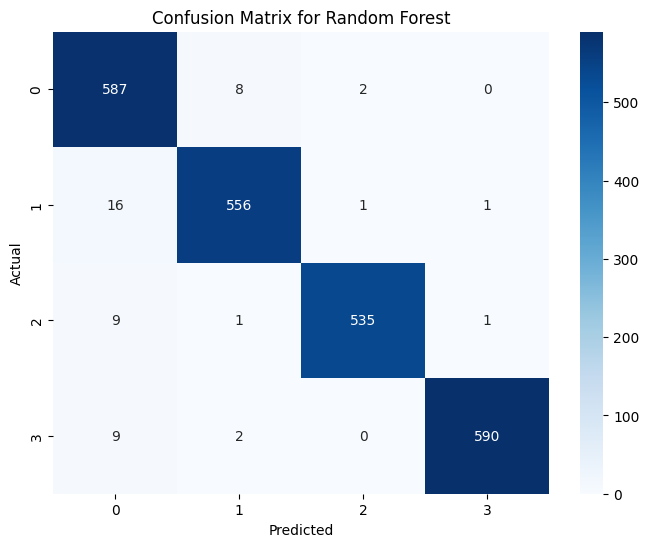

In [115]:
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(Y_test, y_pred)

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Random Forest')
plt.show()